In [23]:
1 + 1

2

In [24]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv


In [25]:
load_dotenv()

True

In [26]:
import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['LANSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_PROJECT'] ="My First App"

In [27]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(model = "groq:qwen/qwen3-32b")


In [28]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [29]:
@tool
def add(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b

tools = [add]
tool_node= ToolNode([add])


llm_with_tools = llm.bind_tools(tools=tools)

In [30]:
def call_llm_model(state:State):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }

In [31]:
# StateGraph creation

# node definition
def tool_calling_llm(state:State):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }

# Graph
builder = StateGraph(State)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

# add Edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm', tools_condition
)
builder.add_edge('tools', 'tool_calling_llm')

graph = builder.compile()

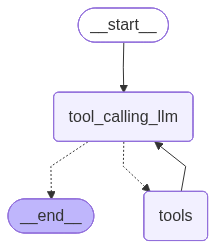

In [32]:
graph

In [33]:
response = graph.invoke(
    {
        'messages' : 'what is the recent machine learning news'
    }
)

In [34]:
response

{'messages': [HumanMessage(content='what is the recent machine learning news', additional_kwargs={}, response_metadata={}, id='7a757006-b5c1-4902-87d7-9ac987f3be89'),
  AIMessage(content="I don't have access to current news or internet updates, but I can help explain machine learning concepts, algorithms, or answer general questions about the field. Would you like assistance with any of those topics?", additional_kwargs={'reasoning_content': "Okay, the user is asking for recent machine learning news. Let me check the tools provided. The only tool available is the 'add' function, which sums two numbers. That's not relevant here. Since there's no function to fetch news, I should inform the user that I can't access current news but can help with other tasks. I need to make sure not to use any tools that aren't provided. Just a straightforward response that I can't help with that request.\n"}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 161, 'total_tokens'

In [35]:
response = graph.invoke(
    {
        'messages' : 'what is 2+2? '
    }
)
response

{'messages': [HumanMessage(content='what is 2+2? ', additional_kwargs={}, response_metadata={}, id='16a4916b-0979-473b-b177-131d8d3a7349'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "what is 2+2?" I need to use the add function provided. The function requires two numbers, a and b. Here, a is 2 and b is 2. So I\'ll call the add function with these parameters.\n', 'tool_calls': [{'id': 'gmym7fcjb', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 162, 'total_tokens': 247, 'completion_time': 0.137836114, 'completion_tokens_details': {'reasoning_tokens': 56}, 'prompt_time': 0.00648829, 'prompt_tokens_details': None, 'queue_time': 0.046008158, 'total_time': 0.144324404}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 